# NLP Project
## Emotion classification 

This is an NLP processing project based on Google's dataset [GoEmotions](https://research.google/blog/goemotions-a-dataset-for-fine-grained-emotion-classification/)

In this section, I present the goal of the project: to apply state-of-the-art NLP techniques to classify multiple emotions in short texts, using Google's GoEmotions dataset. The chosen model is BERT, fine-tuned with PyTorch and Hugging Face Transformers.

Main objectives:

- Fine-tuning of pre-trained model (bert-base-uncased)
- Multi-label classification (28 emotion classes)
- Export and deployment with FastAPI

# Install required libraries

Import essential libraries for the project. Includes:

- PyTorch: backend for training.
- Transformers: pre-trained models and tokenizers.
- Datasets: loading from GoEmotions.
- Scikit-learn: evaluation metrics.

In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers datasets
!pip install scikit-learn matplotlib

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datasets import load_dataset

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer, pipeline

from sklearn.metrics import f1_score, accuracy_score

In [40]:
model_name = 'bert-base-uncased'

# Dataset Exploration & Loading

Using the datasets library to automatically load the GoEmotions dataset.
This dataset contains over 58,000 examples of short texts annotated with multiple emotions, ideal for multi-label problems.

Actions in this step:

Analyze the characteristics of the dataset.

Check the distribution of labels for possible imbalance problems.

In [41]:
dataset = load_dataset("go_emotions")
print(dataset["train"][0]) 

{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [42]:
dataset["train"]["text"][:10]

["My favourite food is anything I didn't have to cook myself.",
 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead',
 'WHY THE FUCK IS BAYLESS ISOING',
 'To make her feel threatened',
 'Dirty Southern Wankers',
 "OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.",
 'Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝',
 'We need more boards and to create a bit more space for [NAME]. Then we’ll be good.',
 'Damn youtube and outrage drama is super lucrative for reddit',
 'It might be linked to the trust factor of your friend.']

In [43]:
emotions = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral",
]

Create a dict with each emotion ocurrence

In [44]:
counts = [0] * len(emotions)

for split in dataset: # train, validation, test
    for sample in dataset[split]:
        emotions_sample = sample["labels"]
        for emotion in emotions_sample:
            counts[emotion] += 1

emotions_count = dict(zip(emotions, counts))
print(emotions_count)

{'admiration': 5122, 'amusement': 2895, 'anger': 1960, 'annoyance': 3093, 'approval': 3687, 'caring': 1375, 'confusion': 1673, 'curiosity': 2723, 'desire': 801, 'disappointment': 1583, 'disapproval': 2581, 'disgust': 1013, 'embarrassment': 375, 'excitement': 1052, 'fear': 764, 'gratitude': 3372, 'grief': 96, 'joy': 1785, 'love': 2576, 'nervousness': 208, 'optimism': 1976, 'pride': 142, 'realization': 1382, 'relief': 182, 'remorse': 669, 'sadness': 1625, 'surprise': 1330, 'neutral': 17772}


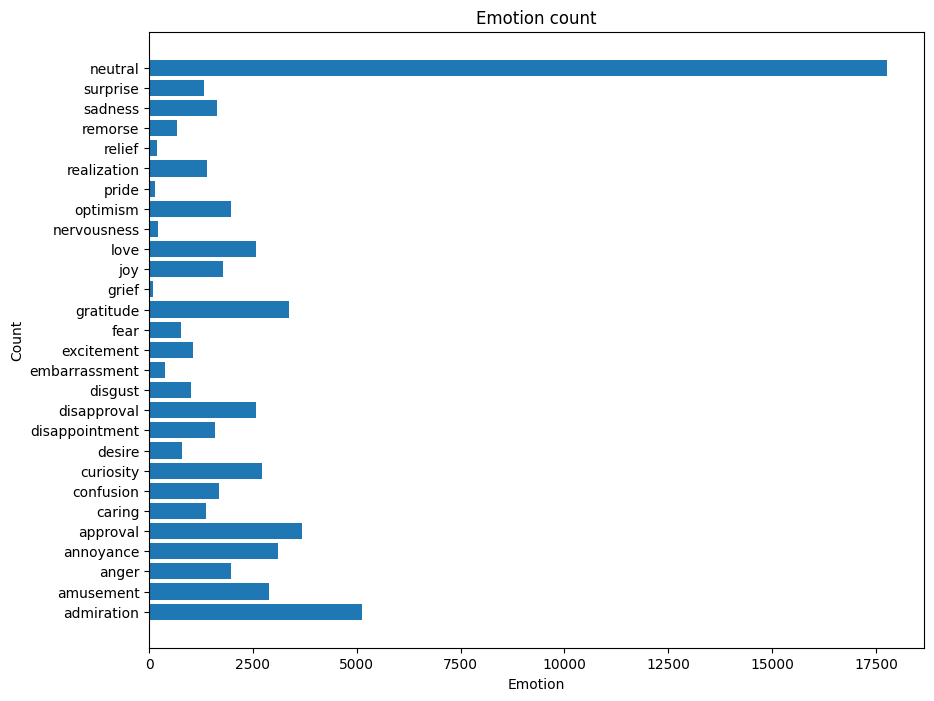

In [46]:
plt.figure(figsize=(10, 8))
plt.barh(emotions_count.keys(), emotions_count.values())
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.title("Emotion count")
plt.show()

It is clearly visible that our dataset is unbalanced in respect to the emotions distribution. But, for the purpose of this project it's enough.

# Multi-hot encoding

For this kind of multi label classification tasks as this, it's necessary to convert the integer values to multi-hot encoded vectors.

In [47]:
def multi_hot_encode(samples):
    multi_hot = np.zeros(len(emotions))

    for label in samples["labels"]:
        multi_hot[label] = 1

    return {"labels": multi_hot.tolist()}

dataset = dataset.map(multi_hot_encode)

In [48]:
print(dataset["train"][7]["labels"])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


# Tokenizing


In [49]:
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 5427/5427 [00:02<00:00, 2363.89 examples/s]


In [50]:
print(tokenized_dataset["train"][7])

{'text': 'We need more boards and to create a bit more space for [NAME]. Then we’ll be good.', 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 'id': 'ef4qmod', 'input_ids': [101, 2057, 2342, 2062, 7923, 1998, 2000, 3443, 1037, 2978, 2062, 2686, 2005, 1031, 2171, 1033, 1012, 2059, 2057, 1521, 2222, 2022, 2204, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Now we need to convert all values from our dataset to a Pytorch friendly format, such as `torch.tensors`

In [51]:
# Change `__getitem__` return format
tokenized_dataset.set_format("torch")

print(tokenized_dataset["train"][7])

{'text': 'We need more boards and to create a bit more space for [NAME]. Then we’ll be good.', 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0]), 'id': 'ef4qmod', 'input_ids': tensor([ 101, 2057, 2342, 2062, 7923, 1998, 2000, 3443, 1037, 2978, 2062, 2686,
        2005, 1031, 2171, 1033, 1012, 2059, 2057, 1521, 2222, 2022, 2204, 1012,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,

## Labels conversion to float

When using `BertForSequenceClassification` with `problem_type="multi_label_classification"`, the model internally relies on the `BCEWithLogitsLoss` function, which **requires target labels to be of type `float`**.
Originally, the labels were of type `int` (`LongTensor`), which would trigger the following runtime error during training:

*RuntimeError: result type Float can't be cast to the desired output type Long*

To ensure compatibility with the expected input of the loss function, we need to convert the label tensors from `int` to `float` using the `.map()` method, while preserving the `"labels"` column name.

In [52]:
convert_to_float = lambda sample: {"float_labels": sample["labels"].to(torch.float)}

tokenized_dataset = (tokenized_dataset
                     .map(convert_to_float, remove_columns=["labels"])
                     .rename_column("float_labels", "labels"))

Map: 100%|██████████| 5427/5427 [00:03<00:00, 1594.33 examples/s]


In [53]:
print(tokenized_dataset["train"][0])

{'text': "My favourite food is anything I didn't have to cook myself.", 'id': 'eebbqej', 'input_ids': tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'token_type_ids': tensor([0, 0, 0, 0, 0,

# Model Definition: Fine-tuning BERT

In this section, I define the base BertForSequenceClassification model with problem_type='multi_label_classification'.

Motivations:
- To harness the power of BERT in natural language understanding.
- To fine-tune the output layer for multiple simultaneous emotions.

In [54]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(emotions),
    problem_type="multi_label_classification"
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then configure the model to use GPU

In [55]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model = model.to(device)

cuda:0


# Hyperparameter Configuration and Training

Configuration of training arguments via TrainingArguments and training with Trainer.

Hyperparameters defined:

Learning rate

Batch size

Number of epochs

Evaluation strategy (eval_strategy='epoch')

Note:
Use fp16=True to speed up training with lower memory consumption (Mixed Precision).

In [56]:
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 10
WEIGHT_DECAY = 1e-2

In [57]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    fp16=True  # mixed precision
)

In [58]:
def compute_metrics(pred):
    logits, labels = pred
    preds = (logits > 0.5).astype(int)  # threshold para multi-label, ajustável!

    f1 = f1_score(labels, preds, average='micro')  
    acc = accuracy_score(labels, preds)

    return {
        'f1': f1,
        'accuracy': acc
    }

In [59]:
# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)


In [60]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.097600,0.090551,0.429976,0.286899
2,0.081000,0.083225,0.506655,0.367238
3,0.067500,0.084109,0.547904,0.413857
4,0.058700,0.090021,0.550490,0.425097
5,0.047300,0.096955,0.561726,0.445366
6,0.037900,0.102772,0.563456,0.456606
7,0.032100,0.108690,0.563091,0.455500
8,0.026700,0.114891,0.561367,0.458080
9,0.023800,0.117157,0.565542,0.460107
10,0.021000,0.117953,0.568500,0.463424


TrainOutput(global_step=27140, training_loss=0.05279135978125261, metrics={'train_runtime': 4178.8828, 'train_samples_per_second': 103.879, 'train_steps_per_second': 6.495, 'total_flos': 2.85607930586112e+16, 'train_loss': 0.05279135978125261, 'epoch': 10.0})

Save the model for later use

In [61]:
model.save_pretrained("./goemotions-bert")
tokenizer.save_pretrained("./goemotions-bert")

('./goemotions-bert/tokenizer_config.json',
 './goemotions-bert/special_tokens_map.json',
 './goemotions-bert/vocab.txt',
 './goemotions-bert/added_tokens.json')

# Testing the pretrained model

In [ ]:
multilabel_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,  # return all pedictions
)

Device set to use cuda:0


In [85]:
result = multilabel_pipeline("I hate you, but i also like you")
result

[[{'label': 'LABEL_18', 'score': 0.87716144323349},
  {'label': 'LABEL_2', 'score': 0.5456488728523254},
  {'label': 'LABEL_0', 'score': 0.06441766768693924},
  {'label': 'LABEL_3', 'score': 0.026155617088079453},
  {'label': 'LABEL_10', 'score': 0.022629201412200928},
  {'label': 'LABEL_11', 'score': 0.02132808230817318},
  {'label': 'LABEL_4', 'score': 0.019050901755690575},
  {'label': 'LABEL_15', 'score': 0.013636835850775242},
  {'label': 'LABEL_17', 'score': 0.006797531619668007},
  {'label': 'LABEL_27', 'score': 0.006413164082914591},
  {'label': 'LABEL_5', 'score': 0.006073934491723776},
  {'label': 'LABEL_25', 'score': 0.004399413242936134},
  {'label': 'LABEL_8', 'score': 0.0027900375425815582},
  {'label': 'LABEL_20', 'score': 0.002693914109840989},
  {'label': 'LABEL_9', 'score': 0.002191240666434169},
  {'label': 'LABEL_22', 'score': 0.001622967072762549},
  {'label': 'LABEL_6', 'score': 0.001560889300890267},
  {'label': 'LABEL_21', 'score': 0.001356401713564992},
  {'lab

In [ ]:
def get_emotion(pred):
    """
    Gets the int number after the _ in "LABEL_X"
    e.g.: LABEL_18 yields just the integer 18
    We use this integer as index to get the original emotion name
    """
    pred_emotion_idx = int(pred["label"].split('_')[1])  
    return emotions[pred_emotion_idx]

predicted_emotions = [get_emotion(pred) for pred in result[0] if pred["score"] > 0.1]
predicted_emotions

['anger', 'love']

# Próximos Passos 

Deploy com FastAPI

Descrição:
- Recebe texto via requisição HTTP.
- Tokeniza.
- Retorna as emoções detectadas.

